In [1]:
import numpy as np

np.random.seed(0)

import torch

torch.manual_seed(0)
torch.set_default_dtype(torch.double)

import gpytorch

import pandas as pd

import matplotlib
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble='\\usepackage{color}')

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["image.cmap"] = "magma"

import ternary

from tqdm import tqdm

In [2]:
num_iters = 5000

scale = 50

In [3]:
parents = ["Al", "Ba", "Si"]
# target = "Enthalpy Relative to Elements (meV/atom)"
target = "E_hull (meV/atom)"

df = pd.read_csv("../data/AlBaSi.csv")[parents + [target]]

train_x = df[parents].values
train_x = torch.tensor(train_x).double()

train_y = df[target].values
train_y = torch.tensor(train_y).double()

mean_y = train_y.mean().item()
stddev_y = train_y.std().item()
train_y = (train_y - mean_y) / stddev_y
unnormalize_fn = lambda x: (x * stddev_y + mean_y, x * stddev_y)

In [4]:
mean_y, stddev_y

(-163.72384025270244, 135.7483859028839)

In [5]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=3)
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

In [7]:
(
    model.mean_module.constant.item(),
    model.covar_module.outputscale.item(),
    model.covar_module.base_kernel.lengthscale.detach().numpy()
)

(0.0, 0.6931471805599453, array([[0.69314718, 0.69314718, 0.69314718]]))

In [8]:
# train the hyperparameter
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()

losses = []
constants = []
outputscales = []
lengthscales = []

for i in tqdm(range(num_iters)):
    optimizer.zero_grad()

    output = model(train_x)
    loss = -mll(output, train_y)

    loss.backward()
    
    losses.append(loss.item())
    constants.append(model.mean_module.constant.item())
    outputscales.append(model.covar_module.outputscale.item())
    lengthscales.append(model.covar_module.base_kernel.lengthscale.detach().numpy())

    optimizer.step()

model.eval()
likelihood.eval()

lengthscales = np.vstack(lengthscales)

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/quannguyen/anaconda3/envs/drew2/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
100%|██████████| 5000/5000 [00:11<00:00, 425.72it/s]


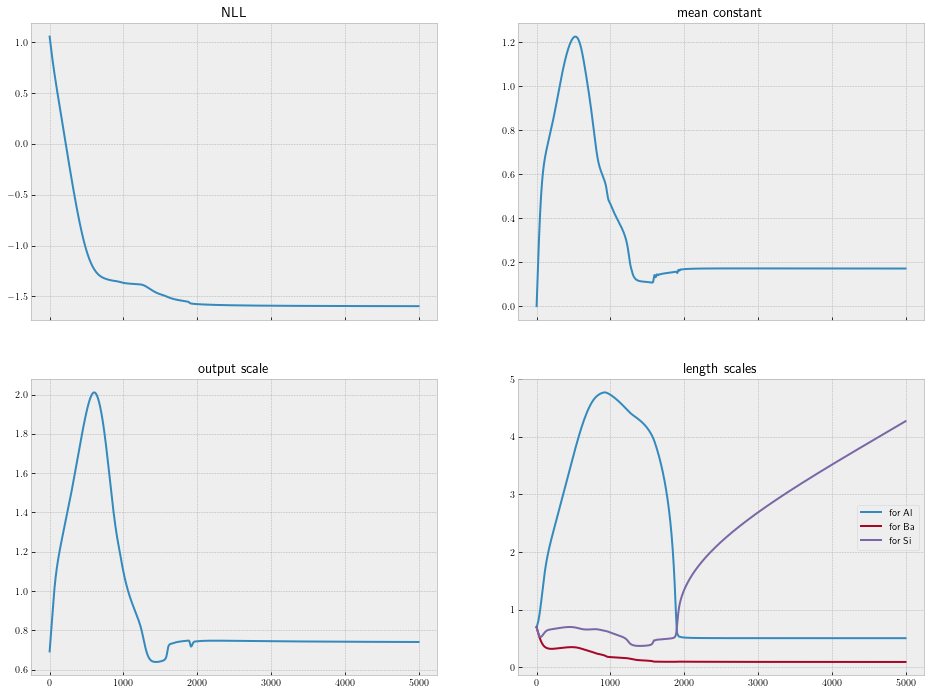

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

ax[0][0].plot(losses)
ax[0][0].set_title("NLL")

ax[0][1].plot(constants)
ax[0][1].set_title("mean constant")

ax[1][0].plot(outputscales)
ax[1][0].set_title("output scale")

for i in range(3):
    ax[1][1].plot(lengthscales[:, i], label=f"for {parents[i]}")
ax[1][1].legend()
ax[1][1].set_title("length scales")

plt.show()

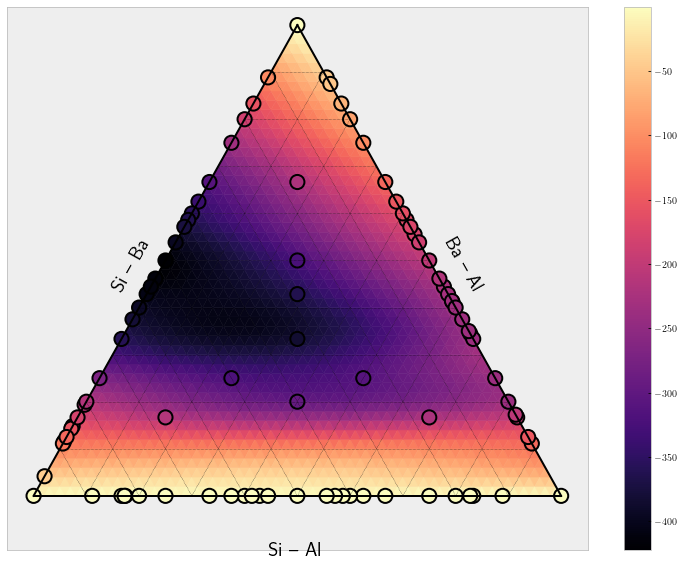

In [10]:
def predict_mean(x):
    x = np.atleast_2d(np.array(x))
    
    with torch.no_grad():
        mean = model(torch.tensor(x).double()).mean
        mean = unnormalize_fn(mean)[0]
        
    return mean.detach().item()


figure, ax = plt.subplots(figsize=(13, 10))
tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)

tax.boundary(linewidth=2.0)
tax.gridlines(multiple=scale / 10, color="k")

tax.heatmapf(
    predict_mean, 
    vmin=df[target].values.min(), 
    vmax=df[target].values.max(), 
    cmap=plt.cm.magma,
)

tax.scatter(
    df[parents].values * scale, 
    c=df[target].values, 
    edgecolors="k",
    linewidth=2,
    vmin=df[target].values.min(), 
    vmax=df[target].values.max(), 
    s=200,
    colormap=plt.cm.magma,
    cmap=plt.cm.magma
)

tax.right_axis_label("Ba – Al", fontsize=20)
tax.left_axis_label("Si – Ba", fontsize=20)
tax.bottom_axis_label("Si – Al", fontsize=20)

tax.clear_matplotlib_ticks()

tax.show()

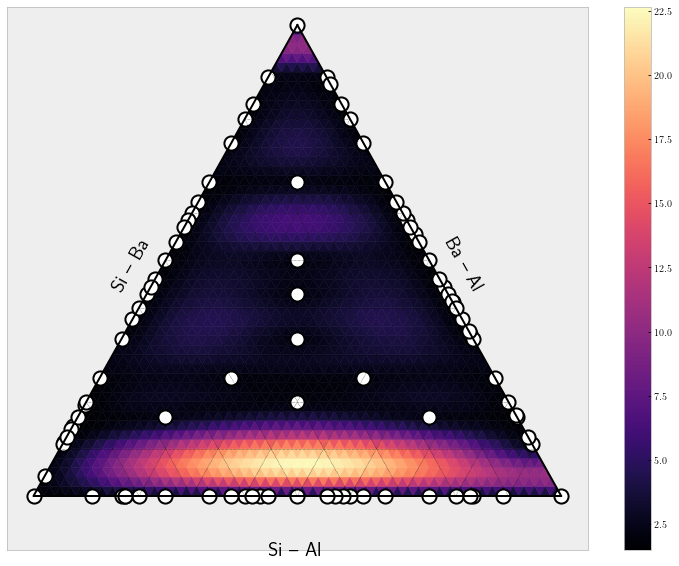

In [11]:
def predict_stddev(x):
    x = np.atleast_2d(np.array(x))
    
    with torch.no_grad():
        stddev = likelihood(model(torch.tensor(x).double())).stddev
        stddev = unnormalize_fn(stddev)[1]
        
    return stddev.detach().item()


figure, ax = plt.subplots(figsize=(13, 10))
tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)

tax.boundary(linewidth=2.0)
tax.gridlines(multiple=scale / 10, color="k")

tax.heatmapf(
    predict_stddev, 
    cmap=plt.cm.magma,
)

tax.scatter(
    df[parents].values * scale, 
    c="w", 
    edgecolors="k",
    linewidth=2,
    s=200,
)

tax.right_axis_label("Ba – Al", fontsize=20)
tax.left_axis_label("Si – Ba", fontsize=20)
tax.bottom_axis_label("Si – Al", fontsize=20)

tax.clear_matplotlib_ticks()

tax.show()

In [12]:
num_steps = 101

test_x = []

for x0 in torch.linspace(0, 1, 101):
    for x1 in torch.linspace(0, 1, 101):
        if x0 + x1 > 1 and not torch.isclose(x0 + x1, torch.ones(1)):
            break
        else:
            test_x.append(torch.tensor([x0, x1, 1 - x0 - x1]).double())
            
test_x = torch.vstack(test_x)
test_x.shape

torch.Size([5151, 3])

In [13]:
%%time

np.random.seed(0)

with torch.no_grad():
    output = likelihood(model(test_x))
    
    sample = np.random.multivariate_normal(
        mean=output.mean.detach().numpy(),
        cov=output.covariance_matrix.detach().numpy(),
        size=1
    )

CPU times: user 6min 10s, sys: 15.7 s, total: 6min 26s
Wall time: 1min 9s


In [14]:
sample = unnormalize_fn(sample.flatten())[0]
sample.shape

(5151,)

In [15]:
sample

array([  2.79607683, -10.69541513, -20.0496652 , ...,   1.09989935,
        -7.47562297,   0.71559999])

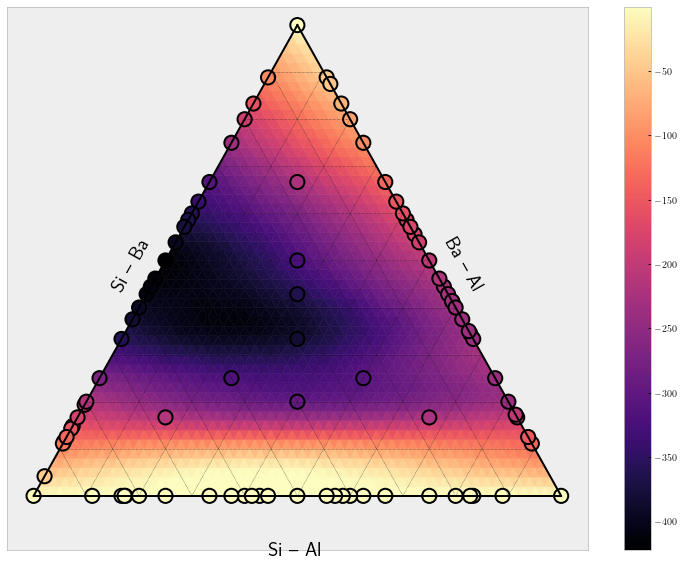

In [16]:
def match_sample(x):
    x = torch.tensor(x).double()
    
    mask = (
        torch.isclose(test_x[:, 0], x[0])
        * torch.isclose(test_x[:, 1], x[1])
        * torch.isclose(test_x[:, 2], x[2])
    )
    
    return sample[mask].item()


figure, ax = plt.subplots(figsize=(13, 10))
tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)

tax.boundary(linewidth=2.0)
tax.gridlines(multiple=scale / 10, color="k")

tax.heatmapf(
    match_sample, 
    vmin=df[target].values.min(), 
    vmax=df[target].values.max(), 
    cmap=plt.cm.magma,
)

tax.scatter(
    df[parents].values * scale, 
    c=df[target].values, 
    edgecolors="k",
    linewidth=2,
    vmin=df[target].values.min(), 
    vmax=df[target].values.max(), 
    s=200,
    colormap=plt.cm.magma,
    cmap=plt.cm.magma
)

tax.right_axis_label("Ba – Al", fontsize=20)
tax.left_axis_label("Si – Ba", fontsize=20)
tax.bottom_axis_label("Si – Al", fontsize=20)

tax.clear_matplotlib_ticks()

tax.show()